In [15]:
import logging
from sentinelhub import MimeType, CRS, BBox, DataCollection, bbox_to_dimensions
from sentinelhub import SHConfig, SentinelHubRequest

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [16]:
logging.basicConfig(level=logging.INFO)

In [17]:
# Load configuration for sentinel-hub API.
config = SHConfig()

config = SHConfig(instance_id='',
         sh_client_id='e0b127dc-fbb5-4151-8946-96d8728003c7',
         sh_client_secret='4Xy2[Bc#?&L!xbha(XB6*%Xbry,BU-cZA0Dd9n,W',
         sh_base_url='https://services.sentinel-hub.com',
         sh_token_url='https://services.sentinel-hub.com/oauth/token',
)

In [18]:
# config = SHConfig()
config.instance_id = "my-instance-id"
config.save("my-profile")

In [19]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

# Your client credentials
client_id = 'e0b127dc-fbb5-4151-8946-96d8728003c7'
client_secret = '4Xy2[Bc#?&L!xbha(XB6*%Xbry,BU-cZA0Dd9n,W'

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_secret=client_secret)

# All requests using this session will have an access token automatically added
resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")
print(resp.content)

b'{"sub":"0779a952-45ee-49cc-bf3c-b99ba53e9fd5","aud":"e0b127dc-fbb5-4151-8946-96d8728003c7","jti":"7d2540f9-566d-4312-a73d-5e39022d0b09","exp":1698060029,"name":"Mike Coulbert","email":"farshad94.am@gmail.com","given_name":"Mike","family_name":"Coulbert","sid":"601aa706-2169-450a-853b-94dab6951d42","did":1,"aid":"1bff7aab-7cfb-48d2-bd2d-de21fc5b44f3","account":"1bff7aab-7cfb-48d2-bd2d-de21fc5b44f3","d":{"1":{"ra":{"rag":1},"t":11000}},"active":true}'


In [20]:
# Bands are set in reverse order.
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [3.5*sample.B04, 3.5*sample.B03, 3.5*sample.B02];

    }
"""

In [38]:
def request_images(coords_wgs84, timeline):
    """
    Arguments:
        coords_wgs84: WGS84 coordinates (e.g. bboxfinder.com)
        timeline: List of time intervals represented as "yyyy-mm-dd"

    Returns:
        List of images represented as NxMx3 Numpy arrays
    """

    # Set resolution and region bb/size.
    resolution = 10
    region_bbox = BBox(bbox = coords_wgs84, crs = CRS.WGS84)
    region_size = bbox_to_dimensions(region_bbox, resolution = resolution)
    print(f'Requesting images with {resolution}m resolution and region size of {region_size} pixels')

    images = []
    for time_int in timeline:

        # Build the request.
        request_true_color = SentinelHubRequest(
            data_folder='sentinel-hub',
            #resolution = resolution,
            evalscript = evalscript_true_color,
            input_data = [
                SentinelHubRequest.input_data(
                    data_collection = DataCollection.SENTINEL2_L1C,
                    time_interval = time_int,
                    mosaicking_order = 'leastCC'
                )
            ],
            responses = [
                SentinelHubRequest.output_response('default', MimeType.PNG)
            ],
            bbox = region_bbox,
            size = region_size,
            config = config
        )

        # By construction, only one image at time is returned.
        true_color_imgs = request_true_color.get_data(save_data=True)
        images.append(true_color_imgs[0])

    return images

In [39]:
bbox = [58.488808,23.630371,58.573265,23.699550]
time_interval = [('2023-07-05', '2023-09-25')]

In [40]:
images = request_images(coords_wgs84=bbox, timeline=time_interval)

Requesting images with 10m resolution and region size of (853, 775) pixels


In [41]:
images[0].shape

(775, 853, 3)

In [32]:
from IPython.display import display
display(images[0])

array([[[ 68,  83, 110],
        [ 70,  83, 108],
        [ 66,  79, 103],
        ...,
        [ 64,  81, 105],
        [ 64,  81, 108],
        [ 56,  74, 103]],

       [[ 68,  84, 109],
        [ 67,  82, 107],
        [ 65,  79, 105],
        ...,
        [ 66,  82, 106],
        [ 62,  81, 108],
        [ 59,  75, 102]],

       [[ 70,  83, 107],
        [ 66,  80, 107],
        [ 67,  81, 106],
        ...,
        [ 68,  84, 108],
        [ 60,  79, 107],
        [ 61,  75, 100]],

       ...,

       [[198, 177, 165],
        [216, 182, 167],
        [200, 178, 161],
        ...,
        [ 64,  81, 105],
        [ 63,  81, 103],
        [ 64,  79, 101]],

       [[238, 198, 185],
        [222, 188, 173],
        [211, 173, 163],
        ...,
        [ 67,  82, 105],
        [ 64,  82, 105],
        [ 65,  82, 105]],

       [[209, 186, 175],
        [217, 185, 172],
        [208, 174, 163],
        ...,
        [ 66,  82, 105],
        [ 65,  80, 104],
        [ 65,  82, 104]]

In [24]:
print(len(images))
print(images[0].shape)
print(images[1].shape)

1
(775, 853, 3)


IndexError: list index out of range

In [127]:
images[1][400]

array([0, 0, 0], dtype=uint8)

<Figure size 640x480 with 0 Axes>

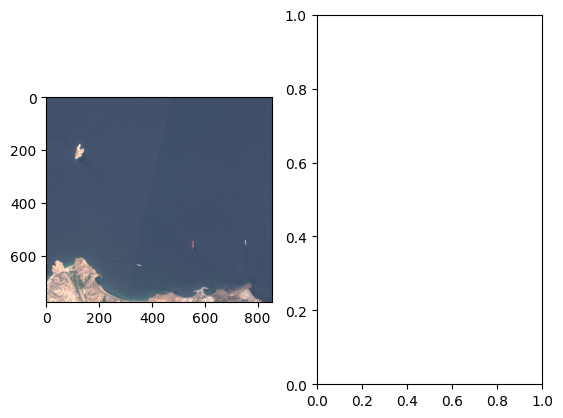

In [37]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(images[0])
# axarr[1].imshow(images[1])

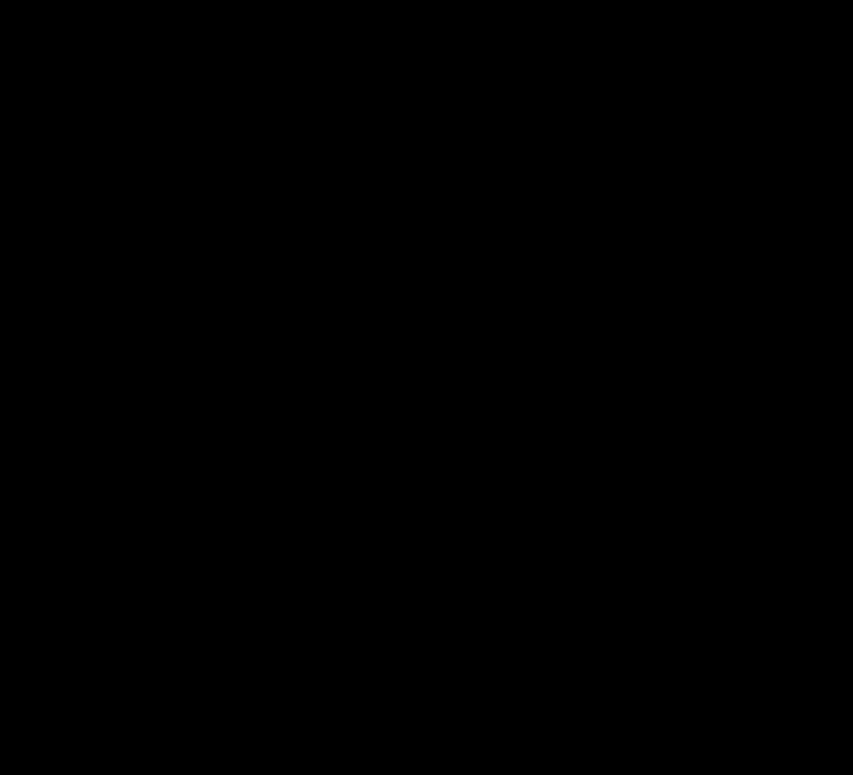

In [121]:
PIL_image = Image.fromarray(np.uint8(images[1])).convert('RGB')
PIL_image